<a href="https://colab.research.google.com/github/klordo/deep_gen_models_hws/blob/hw2/gen_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Генеративно-сотязательные сети, DCGUN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import os
import zipfile
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from PIL import Image
from pathlib import Path
from tqdm import tqdm


## Generator

In [ ]:
class CSPBlock(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=None):
        super(CSPBlock, self).__init__()
        if hidden_channels is None:
            hidden_channels = out_channels
        self.conv1 = nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(hidden_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv2d(hidden_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class Generator(nn.Module):
    def __init__(self, z_dim, img_channels, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            self._block(z_dim, features_g * 16, 4, 1, 0),
            CSPBlock(features_g * 16, features_g * 8),

            self._block(features_g * 8, features_g * 4, 4, 2, 1),
            CSPBlock(features_g * 4, features_g * 2),

            self._block(features_g * 2, features_g, 4, 2, 1),
            CSPBlock(features_g, features_g),

            nn.ConvTranspose2d(features_g, img_channels, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(img_channels, img_channels, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.Tanh()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True),
        )

    def forward(self, input):
        return self.gen(input)

## Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, img_channels, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(img_channels, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.disc(x)

## Dataset

In [ ]:
class CelebADataset(Dataset):
    def __init__(self, image_dir: str | Path, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        image = image.unsqueeze(0)

        return image

## Обучение

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_path = '/content/drive/MyDrive/img_align_celeba/img_align_celeba/'
# image_path = '/content/drive/MyDrive/img_align_celeba/few_imgs/'

In [ ]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Почему-то часто выходят ошибки Input/output error, но раза с третьего срабатывает
celeba_dataset = CelebADataset(image_dir=image_path, transform=transform)

In [ ]:
train_size = int(0.8 * len(celeba_dataset))
test_size = len(celeba_dataset) - train_size

train_dataset, test_dataset = random_split(celeba_dataset, [train_size, test_size])

In [ ]:
batch_siza = 32
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_siza, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_siza, shuffle=True, num_workers=2)

print(f"Загружено изображений: {len(celeba_dataset)}")
print(f"Train: {len(train_dataset)}")
print(f"Test: {len(test_dataset)}")

Загружено изображений: 63628
Train: 50902
Test: 12726


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
z_dim = 100  # шум
img_channels = 3  # RGB
features_d = 128
features_g = 128

In [ ]:
generator = Generator(z_dim, img_channels, features_g).to(device)

In [ ]:
discriminator = Discriminator(img_channels, features_d).to(device)

In [ ]:
lr = 0.0001
beta1 = 0.5
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
criterion = nn.BCELoss()

In [ ]:
def train(train_dataloader):
    G_losses = []
    D_losses = []

    for data in tqdm(train_dataloader):
        discriminator.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        output = discriminator(real_cpu).view(-1)
        label = torch.full((b_size,), 1., dtype=torch.float, device=device)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, z_dim, 1, 1, device=device)
        fake = generator(noise)
        label.fill_(0.)
        output = discriminator(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        generator.zero_grad()
        label.fill_(1.)
        output = discriminator(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        G_losses.append(errG.item())
        D_losses.append(errD.item())

    return G_losses[::10], D_losses[::10]

In [ ]:
@torch.inference_mode()
def test(dataloader):
    G_losses = []
    D_losses = []

    for data in tqdm(dataloader):
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        output = discriminator(real_cpu).view(-1)
        label = torch.full((b_size,), 1., dtype=torch.float, device=device)
        errD_real = criterion(output, label)
        D_x = output.mean().item()

        noise = torch.randn(b_size, z_dim, 1, 1, device=device)
        fake = generator(noise)
        label.fill_(0.)
        output = discriminator(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake

        label.fill_(1.)
        output = discriminator(fake).view(-1)
        errG = criterion(output, label)
        D_G_z2 = output.mean().item()

        G_losses.append(errG.item())
        D_losses.append(errD.item())

    return G_losses[::10], D_losses[::10]

In [ ]:
def train_loop(train_dataloader, test_dataloader, num_epochs=5):
    G_losses_train, D_losses_train = [], []
    G_losses_test, D_losses_test = [], []

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    for epoch in range(num_epochs):

        G_losses_train_temp, D_losses_train_temp = train(train_dataloader)
        G_losses_test_temp, D_losses_test_temp = test(test_dataloader)

        G_losses_train.extend(G_losses_train_temp)
        G_losses_test.extend(G_losses_test_temp)
        D_losses_train.extend(D_losses_train_temp)
        D_losses_test.extend(D_losses_test_temp)

        axs[0].clear()
        axs[1].clear()

        axs[0].set_title("Generator and Discriminator Loss (Training)")
        axs[0].plot(G_losses_train, label="G (Train)")
        axs[0].plot(D_losses_train, label="D (Train)")
        axs[0].set_xlabel("Iterations")
        axs[0].set_ylabel("Loss")
        axs[0].legend()

        axs[1].set_title("Generator and Discriminator Loss (Test)")
        axs[1].plot(G_losses_test, label="G (Test)")
        axs[1].plot(D_losses_test, label="D (Test)")
        axs[1].set_xlabel("Iterations")
        axs[1].set_ylabel("Loss")
        axs[1].legend()

        axs[0].set_xlim(0, 20)
        axs[1].set_xlim(0, 20)

        clear_output(wait=True)
        display(fig)

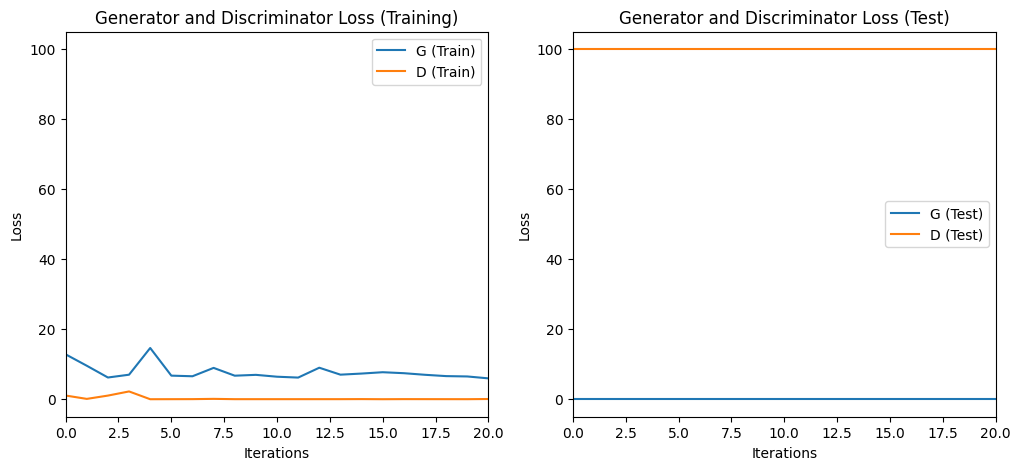

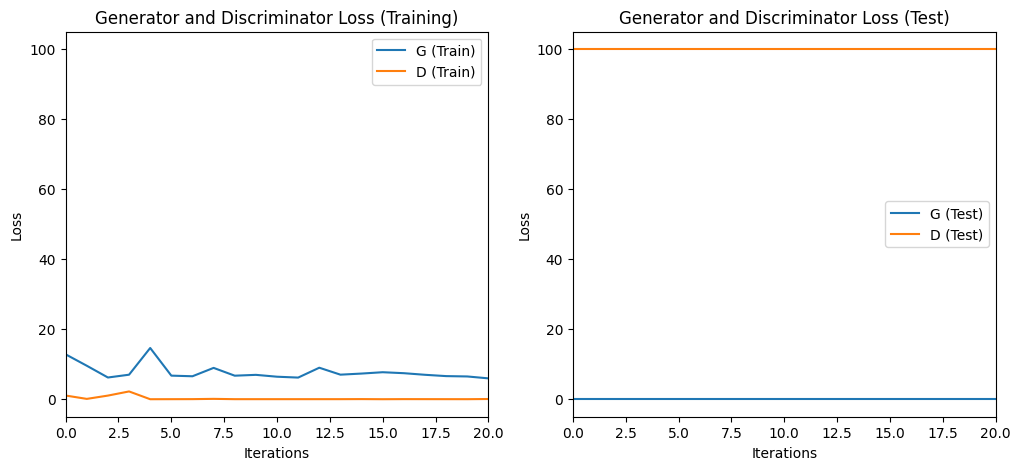

In [ ]:
train_loop(train_dataloader, test_dataloader)

In [ ]:
generator.eval()
noise = torch.randn(1, z_dim, 1, 1, device=device)
fake = generator(noise)
fake.shape

torch.Size([1, 3, 64, 64])

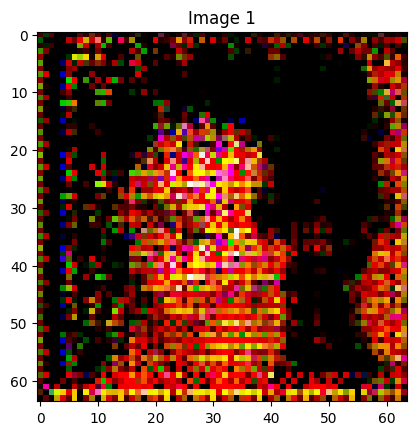

In [ ]:
def show_and_save_tensor_images(tensor):
    if tensor.dim() != 4:
        raise ValueError("Тензор должен быть 4-мерным [b, c, h, w]")

    # (b, c, h, w) -> (b, h, w, c)
    tensor = tensor.permute(0, 2, 3, 1)

    images = tensor.cpu().detach().numpy()

    for i, image in enumerate(images):
        plt.imshow(image)
        plt.title(f"Image {i+1}")
        plt.show()

        pil_img = Image.fromarray((image * 255).astype('uint8'))
        pil_img.save(f"image_{i+1}.png")

show_and_save_tensor_images(fake)